In [1]:
# 📦 Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

matches = pd.read_csv("matches.csv", index_col=0)

# print("Dataset shape:", matches.shape)
matches.head()


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City


# Explore Basic Distributions 
To begin, I want to gain basic insights into Premier League match outcomes. 

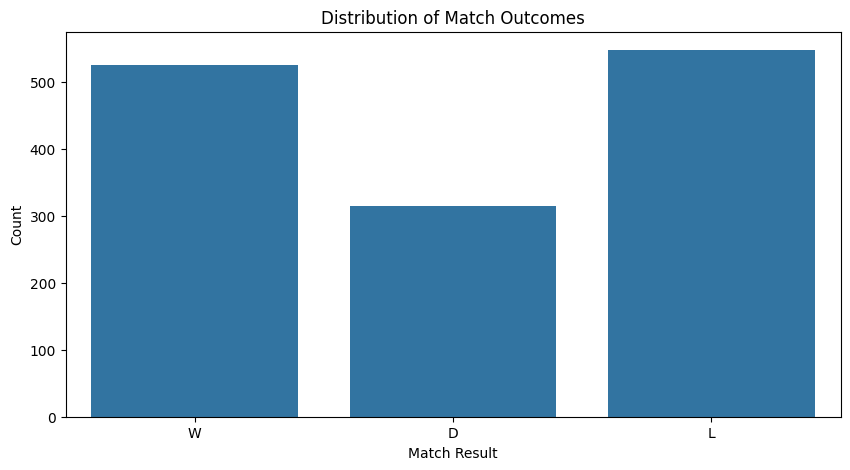

result
L    0.394528
W    0.378690
D    0.226782
Name: proportion, dtype: float64


In [2]:
plt.figure(figsize=(10,5))
sns.countplot(data=matches, x="result", order=["W","D","L"])
plt.title("Distribution of Match Outcomes")
plt.xlabel("Match Result")
plt.ylabel("Count")
plt.show()

print(matches["result"].value_counts(normalize=True))

## Feature Engineering
To train a model, we need to convert the dataset into numerical signals
that describe when, where, and against whom games were played.

In [3]:
matches["date"] = pd.to_datetime(matches["date"])
matches["h/a"] = matches["venue"].astype("category").cat.codes
matches["opp"] = matches["opponent"].astype("category").cat.codes
matches["hour"] = matches["time"].str.replace(":.+", "", regex=True).astype(int)
matches["day"]  = matches["date"].dt.dayofweek
matches["target"] = (matches["result"] == "W").astype(int)

## Visualize Signals We Just Engineered

Here we visualize whether playing at home gives a win advantage.

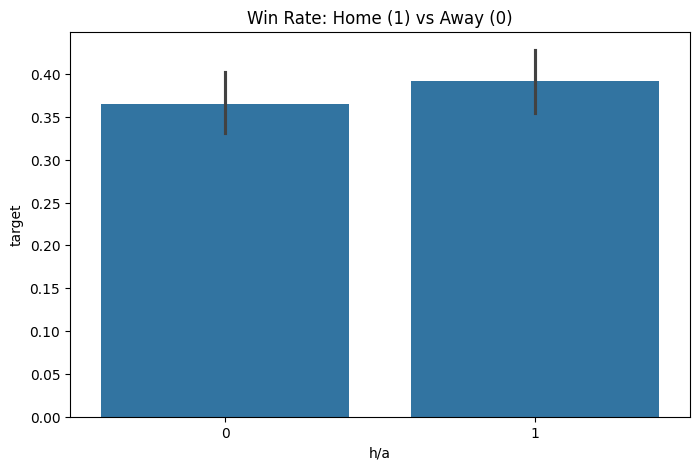

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(data=matches, x="h/a", y="target")
plt.title("Win Rate: Home (1) vs Away (0)")
plt.show()

## Performance by Day of Week

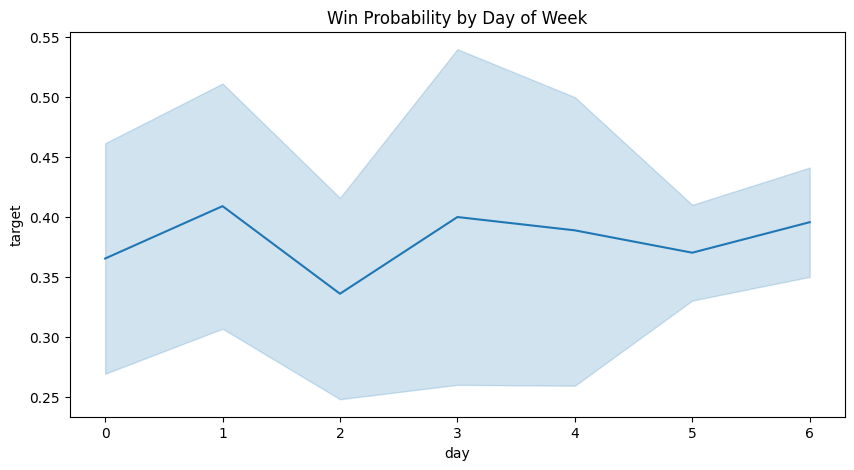

In [5]:
plt.figure(figsize=(10,5))
sns.lineplot(data=matches, x="day", y="target")
plt.title("Win Probability by Day of Week")
plt.show()

## First Machine-Learning Model (Baseline Random Forest)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score

rf = RandomForestClassifier(n_estimators=100, min_samples_split=10, random_state=1)

train = matches[matches["date"] < '2022-01-01']
test  = matches[matches["date"] > '2022-01-01']

predictors = ["h/a", "opp", "hour", "day"]

rf.fit(train[predictors], train["target"])
preds = rf.predict(test[predictors])


## Evaluate Model Performance (Visual + Stats)

Baseline Accuracy: 0.612
Baseline Precision: 0.475
prediction    0   1
actual             
0           140  32
1            75  29


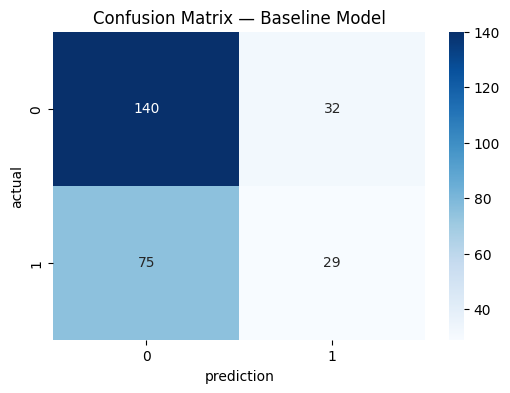

In [8]:
acc = accuracy_score(test["target"], preds)
prec = precision_score(test["target"], preds)

print("Baseline Accuracy:", round(acc,3))
print("Baseline Precision:", round(prec,3))

combined = pd.DataFrame(dict(actual=test["target"], prediction=preds))
ct = pd.crosstab(combined["actual"], combined["prediction"])
print(ct)

plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — Baseline Model")
plt.show()


## Adding Rolling Averages - Capturing Recent Form
Teams don't play the same every week.
To capture a team's form, we compute rolling averages of the last 3 matches.

In [9]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

cols     = ["gf","ga","sh","sot","dist","fk","pk","pkatt"]
new_cols = [f"{c}_rolling" for c in cols]

matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel("team")
matches_rolling.index = range(matches_rolling.shape[0])

/var/folders/87/r6y1hfjd4898yz66lt8h_y7c0000gn/T/ipykernel_48925/78393418.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))


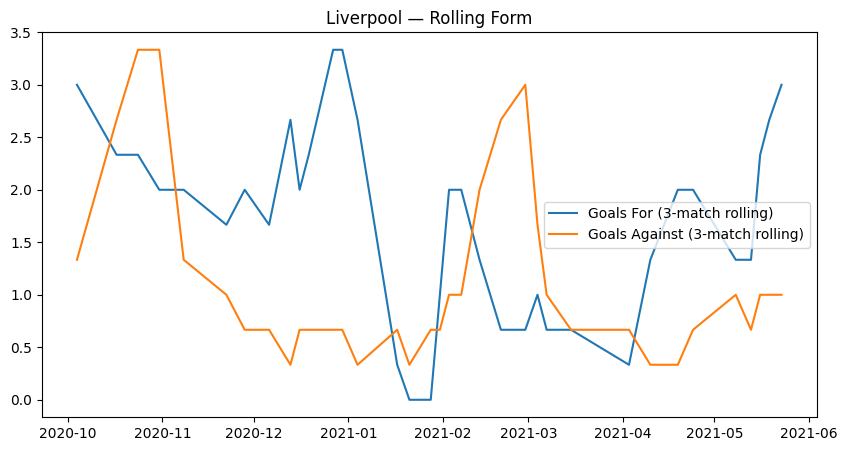

In [44]:
manu = matches_rolling[matches_rolling["team"]=="Liverpool"]

plt.figure(figsize=(10,5))
plt.plot(manu["date"], manu["gf_rolling"], label="Goals For (3-match rolling)")
plt.plot(manu["date"], manu["ga_rolling"], label="Goals Against (3-match rolling)")
plt.title("Liverpool — Rolling Form")
plt.legend()
plt.show()

In [12]:
def make_predictions(data, predictors):
    train = data[data["date"] < '2022-01-01']
    test  = data[data["date"] > '2022-01-01']

    rf.fit(train[predictors], train["target"])
    preds = rf.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], prediction=preds), index=test.index)
    precision = precision_score(test["target"], preds)
    return combined, precision

combined, precision = make_predictions(matches_rolling, predictors + new_cols)

print("📈 Improved Precision with Rolling Averages:", precision)

📈 Improved Precision with Rolling Averages: 0.6739130434782609


/var/folders/87/r6y1hfjd4898yz66lt8h_y7c0000gn/T/ipykernel_48925/2857646131.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Baseline","Rolling Avg"], y=[prec, precision], palette="viridis")


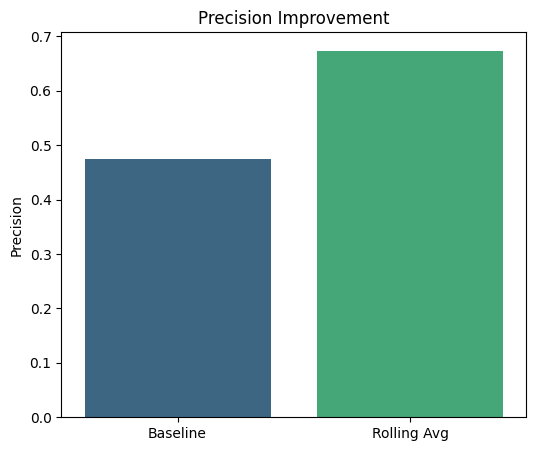

In [13]:
plt.figure(figsize=(6,5))
sns.barplot(x=["Baseline","Rolling Avg"], y=[prec, precision], palette="viridis")
plt.title("Precision Improvement")
plt.ylabel("Precision")
plt.show()


In [46]:
combined = combined.merge(
    matches_rolling[["date","team","opponent","result"]],
    left_index=True, right_index=True
)

In [33]:
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {
    "Brighton and Hove Albion": "Brighton",
    "Manchester United": "Manchester Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves"
}

mapping = MissingDict(**map_values)
combined["new_team"] = combined["team"].map(mapping)

merged = combined.merge(
    combined,
    left_on=["date","new_team"],
    right_on=["date","opponent"]
)

merged.head()

,actual_x,prediction_x,date,team_x,opponent_x,result_x,new_team_x,actual_y,prediction_y,team_y,opponent_y,result_y,new_team_y
0,0,1,2022-01-23,Arsenal,Burnley,D,Arsenal,0,0,Burnley,Arsenal,D,Burnley
1,1,0,2022-02-10,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
2,1,0,2022-02-19,Arsenal,Brentford,W,Arsenal,0,0,Brentford,Arsenal,L,Brentford
3,1,1,2022-02-24,Arsenal,Wolves,W,Arsenal,0,0,Wolverhampton Wanderers,Arsenal,L,Wolves
4,1,1,2022-03-06,Arsenal,Watford,W,Arsenal,0,0,Watford,Arsenal,L,Watford


In [39]:
def build_predicted_results(df):
    """
    Takes the merged prediction table and returns a clean match-level table
    with predicted winners.
    """
    results = []

    for _, row in df.iterrows():
        home = row["team_x"]
        away = row["team_y"]
        pred_home = row["prediction_x"]
        pred_away = row["prediction_y"]

        # Determine predicted result
        if pred_home == 1 and pred_away == 0:
            predicted_result = home
        elif pred_away == 1 and pred_home == 0:
            predicted_result = away
        else:
            predicted_result = "Draw"

        results.append({
            "date": row["date"],
            "home_team": home,
            "away_team": away,
            "predicted_result": predicted_result
        })

    return pd.DataFrame(results)


In [47]:
pred_table = build_predicted_results(merged)
pred_table.head()

pred_table.to_csv("predictions.csv", index=False)

In [41]:
def predicted_win_counts(pred_table):
    win_counts = {}

    for _, row in pred_table.iterrows():
        winner = row["predicted_result"]
        if winner == "Draw":
            continue
        
        win_counts[winner] = win_counts.get(winner, 0) + 1

    win_df = (
        pd.DataFrame(list(win_counts.items()), columns=["team", "predicted_wins"])
        .sort_values("predicted_wins", ascending=False)
        .reset_index(drop=True)
    )
    return win_df


In [42]:
predicted_win_table = predicted_win_counts(pred_table)
predicted_win_table

,team,predicted_wins
0,Manchester City,14
1,Tottenham Hotspur,8
2,Arsenal,6
3,Manchester United,6
4,Newcastle United,5
5,Chelsea,5
6,Southampton,4
7,Brentford,4
8,West Ham United,4
9,Wolverhampton Wanderers,3


In [43]:
top_team = predicted_win_table.iloc[0]
print("Team with the most predicted wins:", top_team["team"])
print("Predicted wins:", top_team["predicted_wins"])

Team with the most predicted wins: Manchester City
Predicted wins: 14
